<a href="https://colab.research.google.com/github/kang9366/Algorithm/blob/main/Training/Eye_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import pandas as pd

# display images
from torchvision import utils
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/data'

In [ ]:
normal = os.listdir(path + '/정상')
conjunctivitis = os.listdir(path + '/결막염')
cataract = os.listdir(path + '/백내장')
keratitis = os.listdir(path + '/색소침착성 각막염')
mastopathy = os.listdir(path + '/유루증')
ulcerative = os.listdir(path + '/궤양성 각막질환')
# tumor = os.listdir(path + '/안검종양')
# nonUlcerative = os.listdir(path + '/비궤양성각막질환 상')
# sclerosis = os.listdir(path + '/핵경화')
# entropion = os.listdir(path + '/안검내반증')
# blepharitis = os.listdir(path + '/안검염')

data = {'class':[],'num':[]}
data['class'] += ['normal', 'conjunctivitis', 'cataract', 'keratitis', 'mastopathy','ulcerative',]
data['num'] += [len(normal), len(conjunctivitis), len(cataract),
                len(keratitis), len(mastopathy), len(ulcerative)]

df = pd.DataFrame(data)
df

,class,num
0,normal,3000
1,conjunctivitis,3000
2,cataract,3000
3,keratitis,3000
4,mastopathy,3000
5,ulcerative,3000


<Axes: xlabel='class', ylabel='num'>

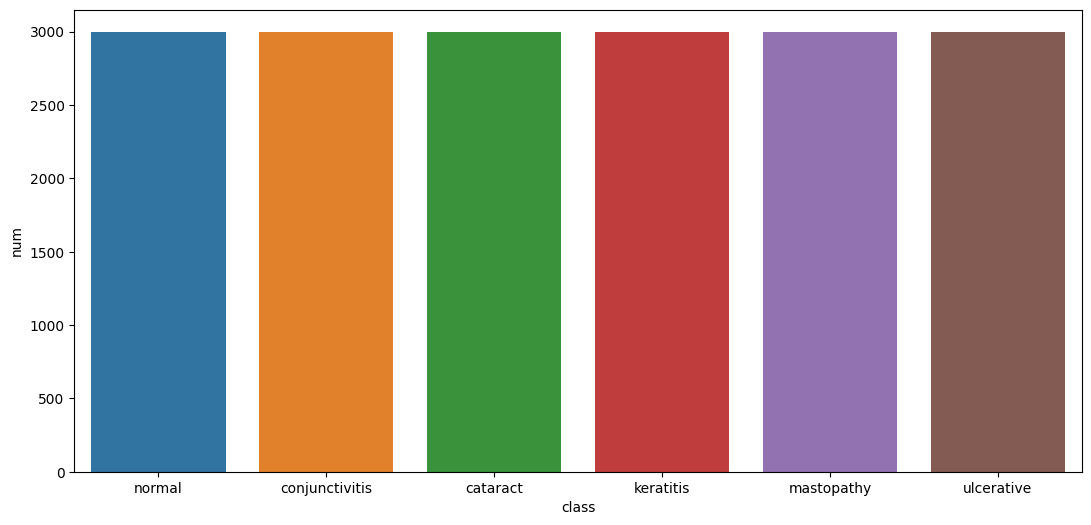

In [ ]:
plt.figure(figsize=(13,6))
sns.barplot(x=df['class'],y=df['num'])

/content/drive/MyDrive/data/백내장/D54_0dc96b30-60a5-11ec-8402-0a7404972c70.jpg
/content/drive/MyDrive/data/색소침착성 각막염/D50_03088cb4-60a5-11ec-8402-0a7404972c70.jpg
/content/drive/MyDrive/data/유루증/D26_03a00b29-60a5-11ec-8402-0a7404972c70.jpg
/content/drive/MyDrive/data/정상/D6_2bb15207-60a5-11ec-8402-0a7404972c70.jpg
/content/drive/MyDrive/data/결막염/D55_20ced802-60a5-11ec-8402-0a7404972c70.jpg
/content/drive/MyDrive/data/궤양성 각막질환/D54_192776fb-60a5-11ec-8402-0a7404972c70.jpg


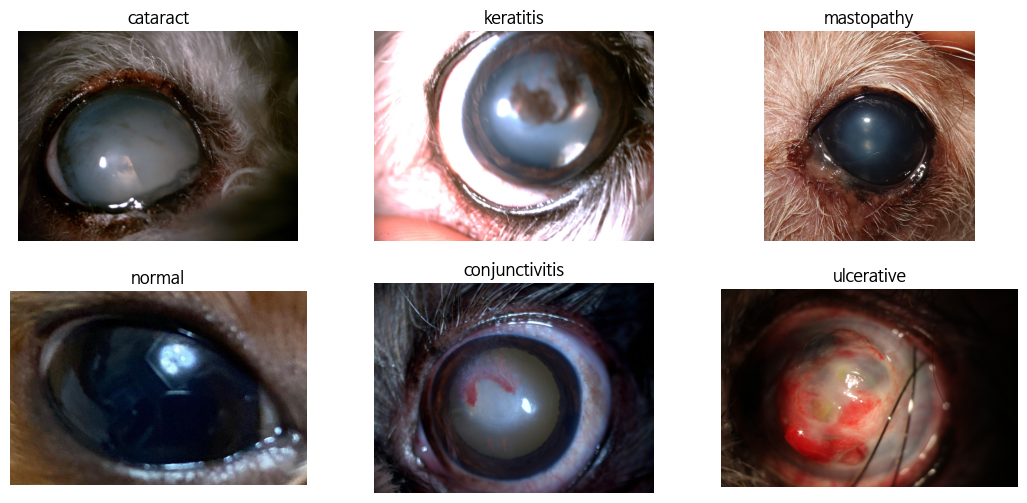

In [ ]:
from matplotlib import font_manager

classes = os.listdir(path)
index = [2,3,4,0,1,5]

plt.figure(figsize=(13,6))

for x in range(6):
    images = os.listdir(path+'/'+classes[x])
    j = random.randint(0,3000)
    image = cv2.imread(path+'/'+classes[x]+'/'+images[j])
    print(path+'/'+classes[x]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, x + 1)
    plt.title(data['class'][index[x]])
    plt.imshow(image)
    plt.axis("off")

plt.show()

# 데이터 불러오기

In [23]:
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [24]:
dataset = ImageFolder('/content/drive/MyDrive/data',
                      transform=transforms.Compose([transforms.Resize((224, 224)),
                                                    transforms.ToTensor(),
                                                    transforms.RandomHorizontalFlip(0.5),
                                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
bs=64


train_size = int(0.7 * len(dataset))
validation_size = int(0.2 * len(dataset))
test_size = int(0.1 * len(dataset))

trainset, validation, test = random_split(dataset, [train_size, validation_size, test_size])

loaders = {
            'train':DataLoader(trainset, batch_size=bs, num_workers=0, pin_memory=False), #, num_workers=4, pin_memory=False
            'val': DataLoader(validation, batch_size=bs, num_workers=0, pin_memory=False),
            'test' : DataLoader(test, batch_size=bs, num_workers=0, pin_memory=False)
          }

dataset_sizes = {
                 'train':len(trainset),
                 'val':len(validation),
                 'test':len(test)
                }
print(dataset_sizes)
print(dataset.classes)

{'train': 10500, 'val': 3000, 'test': 1500}
['결막염', '백내장', '색소침착성 각막염', '유루증', '정상']


## 모델 학습

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    losses = {'train':[], 'val':[]}
    accuracies = {'train':[], 'val':[]}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

In [8]:
def train(model_name, name):
  if __name__ == '__main__':
      print(f'Training {name}...')
      model = model_name.to(device)
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
      exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

      trained_model, losses, accuracies = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
      trained_models[name] = {
          'model': trained_model,
          'losses': losses,
          'accuracies': accuracies
      }

In [10]:
trained_models = {}

## 모델 정의

### MobileNet

In [19]:
mobileNet = models.mobilenet_v2(pretrained=True)
num_features = mobileNet.classifier[1].in_features

mobileNet.classifier[1] = nn.Linear(num_features, len(dataset.classes))
mobileNet = mobileNet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mobileNet.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 139MB/s]


In [20]:
train(mobileNet, "mobileNet")

Training mobileNet...
Epoch 0/9
train Loss: 0.9464 Acc: 0.6153
val Loss: 0.7091 Acc: 0.7033
Epoch 1/9
train Loss: 0.6394 Acc: 0.7393
val Loss: 0.6484 Acc: 0.7393
Epoch 2/9
train Loss: 0.5523 Acc: 0.7783
val Loss: 0.6316 Acc: 0.7573
Epoch 3/9
train Loss: 0.4906 Acc: 0.8047
val Loss: 0.6195 Acc: 0.7680
Epoch 4/9
train Loss: 0.4283 Acc: 0.8332
val Loss: 0.6352 Acc: 0.7567
Epoch 5/9
train Loss: 0.3650 Acc: 0.8592
val Loss: 0.6639 Acc: 0.7600
Epoch 6/9
train Loss: 0.3085 Acc: 0.8892
val Loss: 0.7125 Acc: 0.7560
Epoch 7/9
train Loss: 0.2317 Acc: 0.9242
val Loss: 0.6741 Acc: 0.7680
Epoch 8/9
train Loss: 0.2142 Acc: 0.9302
val Loss: 0.6870 Acc: 0.7593
Epoch 9/9
train Loss: 0.2059 Acc: 0.9362
val Loss: 0.6945 Acc: 0.7627
Training complete in 100m 19s
Best val Acc: 0.768000


In [22]:
torch.save(trained_models['mobileNet']['model'].state_dict(), 'mobileNet.pt')

### GoogleNet

In [ ]:
googlenet = torchvision.models.googlenet(pretrained=True)
for param in googlenet.parameters():
  param.grad_requires = False

googlenet.fc = nn.Linear(in_features=googlenet.fc.in_features, out_features=len(dataset.classes), bias=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 150MB/s]


In [ ]:
train(googlenet, "googleNet")

Training googleNet...
Epoch 0/9
train Loss: 1.0669 Acc: 0.5718
val Loss: 0.7925 Acc: 0.6923
Epoch 1/9
train Loss: 0.7394 Acc: 0.7052
val Loss: 0.6859 Acc: 0.7300
Epoch 2/9
train Loss: 0.6594 Acc: 0.7382
val Loss: 0.6497 Acc: 0.7460
Epoch 3/9
train Loss: 0.6048 Acc: 0.7607
val Loss: 0.6268 Acc: 0.7517
Epoch 4/9
train Loss: 0.5598 Acc: 0.7791
val Loss: 0.6141 Acc: 0.7573
Epoch 5/9
train Loss: 0.5193 Acc: 0.7957
val Loss: 0.6058 Acc: 0.7583
Epoch 6/9
train Loss: 0.4760 Acc: 0.8163
val Loss: 0.6041 Acc: 0.7593
Epoch 7/9
train Loss: 0.4333 Acc: 0.8337
val Loss: 0.6013 Acc: 0.7517
Epoch 8/9
train Loss: 0.4259 Acc: 0.8379
val Loss: 0.5999 Acc: 0.7583
Epoch 9/9
train Loss: 0.4165 Acc: 0.8427
val Loss: 0.6036 Acc: 0.7590
Training complete in 208m 54s
Best val Acc: 0.759333


In [ ]:
torch.save(trained_models['googleNet']['model'].state_dict(), 'googleNet.pt')

### DenseNet

In [11]:
densenet121 = torchvision.models.densenet121(pretrained=True)
for param in densenet121.parameters():
  param.requires_grad=False

densenet121.classifier = nn.Linear(in_features=densenet121.classifier.in_features, out_features=len(dataset.classes), bias=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 96.6MB/s]


In [12]:
train(densenet121, "denseNet")

Training denseNet...
Epoch 0/9
train Loss: 1.1678 Acc: 0.5302
val Loss: 0.9315 Acc: 0.6160
Epoch 1/9
train Loss: 0.8770 Acc: 0.6583
val Loss: 0.8452 Acc: 0.6507
Epoch 2/9
train Loss: 0.8127 Acc: 0.6792
val Loss: 0.8115 Acc: 0.6653
Epoch 3/9
train Loss: 0.7783 Acc: 0.6875
val Loss: 0.7859 Acc: 0.6773
Epoch 4/9
train Loss: 0.7527 Acc: 0.7022
val Loss: 0.7731 Acc: 0.6827
Epoch 5/9
train Loss: 0.7353 Acc: 0.7090
val Loss: 0.7690 Acc: 0.6880
Epoch 6/9
train Loss: 0.7240 Acc: 0.7108
val Loss: 0.7578 Acc: 0.6880
Epoch 7/9
train Loss: 0.7062 Acc: 0.7243
val Loss: 0.7367 Acc: 0.6940
Epoch 8/9
train Loss: 0.7014 Acc: 0.7215
val Loss: 0.7386 Acc: 0.6933
Epoch 9/9
train Loss: 0.7027 Acc: 0.7258
val Loss: 0.7389 Acc: 0.6980
Training complete in 159m 5s
Best val Acc: 0.698000


In [13]:
torch.save(trained_models['denseNet']['model'].state_dict(), 'denseNet.pt')

### ResNet

In [ ]:
resnet101 = torchvision.models.resnet101(pretrained=True)
for param in resnet101.parameters():
  param.grad_requires = False

resnet101.fc = nn.Linear(in_features=resnet101.fc.in_features, out_features=len(dataset.classes), bias=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 427MB/s]


In [ ]:
train(resnet101, "resnet")

Training resnet...
Epoch 0/9
train Loss: 0.8332 Acc: 0.6586
val Loss: 0.6301 Acc: 0.7437
Epoch 1/9
train Loss: 0.5640 Acc: 0.7698
val Loss: 0.5830 Acc: 0.7620
Epoch 2/9
train Loss: 0.4409 Acc: 0.8239
val Loss: 0.5904 Acc: 0.7660
Epoch 3/9
train Loss: 0.3340 Acc: 0.8760
val Loss: 0.6536 Acc: 0.7650
Epoch 4/9
train Loss: 0.2502 Acc: 0.9118
val Loss: 0.7715 Acc: 0.7613
Epoch 5/9
train Loss: 0.1992 Acc: 0.9323
val Loss: 0.7664 Acc: 0.7543
Epoch 6/9
train Loss: 0.1724 Acc: 0.9424
val Loss: 0.8337 Acc: 0.7497
Epoch 7/9
train Loss: 0.1408 Acc: 0.9497
val Loss: 0.7747 Acc: 0.7653
Epoch 8/9
train Loss: 0.1082 Acc: 0.9644
val Loss: 0.8009 Acc: 0.7640
Epoch 9/9
train Loss: 0.0967 Acc: 0.9662
val Loss: 0.8218 Acc: 0.7627
Training complete in 194m 27s
Best val Acc: 0.766000


In [ ]:
torch.save(trained_models['resnet']['model'].state_dict(), 'resnet.pt')

### VGG

In [16]:
vgg19_bn = torchvision.models.vgg19_bn(pretrained=True)
for param in vgg19_bn.parameters():
  param.grad_requires = False

vgg19_bn.classifier[6] = nn.Linear(4096, len(dataset.classes), bias=True)

In [17]:
train(vgg19_bn, "vgg")

Training vgg...
Epoch 0/9
train Loss: 0.9634 Acc: 0.5955
val Loss: 0.7046 Acc: 0.7160
Epoch 1/9
train Loss: 0.6528 Acc: 0.7325
val Loss: 0.6588 Acc: 0.7360
Epoch 2/9
train Loss: 0.5478 Acc: 0.7812
val Loss: 0.6490 Acc: 0.7513
Epoch 3/9
train Loss: 0.4512 Acc: 0.8262
val Loss: 0.6401 Acc: 0.7633
Epoch 4/9
train Loss: 0.3629 Acc: 0.8660
val Loss: 0.6953 Acc: 0.7600
Epoch 5/9
train Loss: 0.2727 Acc: 0.9032
val Loss: 0.7843 Acc: 0.7520
Epoch 6/9
train Loss: 0.2231 Acc: 0.9238
val Loss: 0.8065 Acc: 0.7587
Epoch 7/9
train Loss: 0.1536 Acc: 0.9472
val Loss: 0.7895 Acc: 0.7580
Epoch 8/9
train Loss: 0.1384 Acc: 0.9567
val Loss: 0.7944 Acc: 0.7573
Epoch 9/9
train Loss: 0.1306 Acc: 0.9607
val Loss: 0.8239 Acc: 0.7513
Training complete in 108m 54s
Best val Acc: 0.763333


In [18]:
torch.save(trained_models['vgg']['model'].state_dict(), 'vgg.pt')

In [ ]:
models = {'mobileNet': mobileNet, 'vgg19_bn': vgg19_bn, 'resnet101': resnet101, 'densenet121': densenet121, 'googlenet': googlenet}